In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import PIL.Image
import IPython.display
import io
from ipywidgets import widgets
from IPython.display import Image, display, clear_output
from sklearn.cluster import KMeans
from skimage.segmentation import active_contour
%matplotlib inline


In [2]:
try:
    import piplite
    await piplite.install(['ipywidgets'])
except ImportError:
    pass


# Problem #2 : Path Detection 

### Part one: Edge extraction 

In [3]:
in_img = cv2.imread("./img1.jpg")
Results = []
H,W,_ = in_img.shape
in_img = cv2.resize(in_img,(W//3,H//3),interpolation=cv2.INTER_CUBIC)

Results.append(in_img)
in_img_gray = cv2.cvtColor(in_img,cv2.COLOR_BGR2GRAY)
H,W = in_img_gray.shape

@widgets.interact(t1=(0,500,1),t2=(0,500,1),l2=False,blur=["Blur","Median","Guassian","Bilateral","None"],k=(3,15,2))
def find_parameter_for_canny(t1,t2,l2,blur,k):
    global in_img_gray
    if blur == "Blur":
        in_img_gray1 = cv2.blur(in_img_gray,(k,k))
    elif blur == "Median":
        in_img_gray1 = cv2.medianBlur(in_img_gray,k)
    elif blur == "Guassian":
        in_img_gray1 = cv2.GaussianBlur(in_img_gray,(k,k),sigmaX=6)
    elif blur == "Bilateral":
        in_img_gray1 = cv2.bilateralFilter(in_img_gray,int(k),75,75)
    else:
        in_img_gray1 = in_img_gray.copy()    
        
    edges = cv2.Canny(in_img_gray1,t1,t2,L2gradient=l2)
    a = np.uint8(edges)
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, "png")
    IPython.display.display(IPython.display.Image(data=f.getvalue()))    



interactive(children=(IntSlider(value=250, description='t1', max=500), IntSlider(value=250, description='t2', …

### Part Two: Create mask

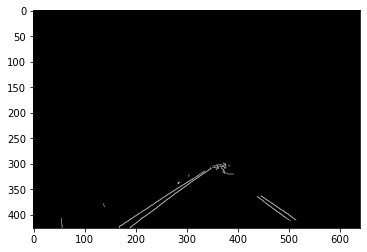

In [4]:
def GetMask(in_img_gray,_w,_h,offset1=0,show=False):
    mask = np.zeros_like(in_img_gray,dtype=np.uint8)
    points = np.array([[0+offset1,H-1],[W-1-offset1,H-1],[W//3*_w,H//3*_h]],dtype=np.int32)
    points = points.reshape(-1,1,2)
    mask = cv2.fillPoly(mask.copy(),[points],color=(255))
    if show:
        plt.imshow(mask,cmap="gray")
        plt.show()
    return mask

mask = GetMask(in_img_gray,1.75,2.1)
Results.append(in_img_gray)

filter_img = cv2.blur(in_img_gray,(3,3))
Results.append(filter_img)
Results.append(mask)

edges = cv2.Canny(filter_img,110,260)
Results.append(edges)
masked_edges = cv2.bitwise_and(mask,edges)
Results.append(masked_edges)
plt.imshow(masked_edges,cmap="gray")
plt.show()

### Part Three: line detection 

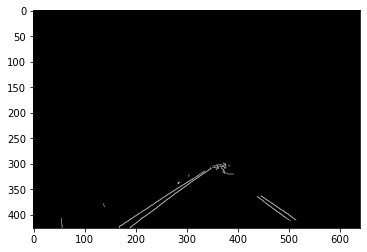

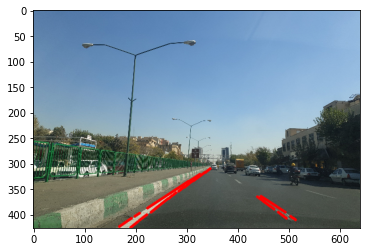

In [5]:
_,masked_edges_bin = cv2.threshold(masked_edges,200,255,cv2.THRESH_BINARY)
Results.append(masked_edges_bin)

plt.imshow(masked_edges_bin,cmap="gray")
plt.show()

cdstP = in_img.copy()
# 30,10,5
linesP = cv2.HoughLinesP(masked_edges_bin,1,np.pi/180,30,10,5)
M = []

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
        m = (l[3]-l[1])/(l[2]-l[0])
        if abs(m) <= 0.8 and abs (m) >= 0.6 :
            M.append(m)

plt.imshow(cdstP[:,:,::-1])
plt.show()

Results.append(cdstP)

### Part Four: Combine line segments

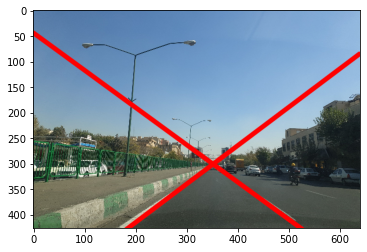

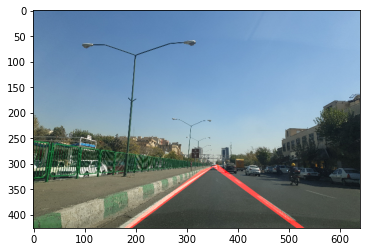

In [6]:
def GetDetectedLines(img_rgb,mask,linesP,n_s=0,p_s=0,alpha=0,show=False,index=0):
    M = []
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            M.append((l[3]-l[1])/(l[2]-l[0]))
    else:
        print("Error")

    M = np.array(M)
    M_2d = np.reshape(M,(M.shape[0],1))
            
    try :
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(M_2d)
        line_slops = kmeans.cluster_centers_
    except:
        line_slops = np.zeros((2,1))
        line_slops[0][0] = n_s 
        line_slops[1][0] = p_s

        
    if (line_slops[0][0] > 0 and line_slops[1][0] > 0) or (line_slops[0][0] < 0 and line_slops[1][0] < 0) :
        line_slops[0][0] = n_s 
        line_slops[1][0] = p_s

        
    if alpha !=0:
        if line_slops[0][0] < 0:
            line_slops[0][0] = alpha*line_slops[0][0] + (1-alpha)*n_s
            line_slops[1][0] = alpha*line_slops[1][0] + (1-alpha)*p_s
        else :
            line_slops[0][0] = alpha*line_slops[0][0] + (1-alpha)*p_s
            line_slops[1][0] = alpha*line_slops[1][0] + (1-alpha)*n_s
        
        
    cdstP = np.zeros_like(img_rgb)
    cdstImg = img_rgb.copy()

    for slope in line_slops:
        try:
            slops = np.abs(M - slope)
            line_index = np.argmin(slops)
        except:
            print(slope,slops,M,linesP)
            return None
        
        x1,y1,x2,y2 = linesP[line_index][0]
        m = M[line_index]
        
        px=0
        py= int(-(x1-0)*m+y1 -1 )
        
        qx=int(W-1)
        qy= int (-(x2-W)*m+y2 -1)
        
        cv2.line(cdstP, (px, py), (qx, qy), (0,0,255), 7, cv2.LINE_AA)
        cv2.line(cdstImg, (px, py), (qx, qy), (0,0,255), 7, cv2.LINE_AA)
        
            
    cdstP[:,:,2] = cv2.bitwise_and(cdstP[:,:,2],mask)
    return cdstImg,cv2.add(cdstP,img_rgb),line_slops[0,0],line_slops[1,0]

cdstImg, final,s1,s2 = GetDetectedLines(in_img,mask,linesP)
Results.append(cdstImg)
Results.append(final)

plt.imshow(cdstImg[:,:,::-1])
plt.show()


plt.imshow(final[:,:,::-1])
plt.show()

### Generate result

In [7]:
new_results = []
for _img in Results:
    if len(_img.shape) != 3 :
        raw = np.zeros_like(in_img)
        for c in range(3):
            raw[:,:,c] = _img
        new_results.append(raw)
    else:
        new_results.append(_img)

v_results = []
index = 1
for i in range(1,len(new_results),2):
    h_result = cv2.vconcat([new_results[i-1],new_results[i]])
    v_results.append(h_result)

    cv2.imwrite("./outputs/P2-{0}.png".format(index),h_result)
    index += 1
    

    

# Problem #3: Video line detection

### Video one

In [8]:
cap = cv2.VideoCapture("./vid1.mp4")
count = 0
show_proc = False
#540 , 960

Frames = []

ns = 0
ps = 0
N = []
P = []

while cap.isOpened():
    ret,in_img = cap.read()
    if in_img is None:
        break
    H,W,_ = in_img.shape
    in_img = cv2.resize(in_img,(W//1,H//1),interpolation=cv2.INTER_CUBIC)
    in_img_gray = cv2.cvtColor(in_img,cv2.COLOR_BGR2GRAY)
    H,W = in_img_gray.shape
    mask = GetMask(in_img_gray,1.5,1.75,20,False)
    filter_img = in_img_gray.copy()
    edges = cv2.Canny(filter_img,110,260)
    masked_edges = cv2.bitwise_and(mask,edges)
    _,masked_edges_bin = cv2.threshold(masked_edges,96,255,cv2.THRESH_BINARY)
    masked_edges_bin = cv2.dilate(masked_edges_bin, None, iterations=2)
    masked_edges_bin = cv2.erode(masked_edges_bin, None, iterations=1)


    linesP = cv2.HoughLinesP(masked_edges_bin,1,np.pi/180,40,50,10)
    
    cdstP = np.zeros_like(in_img)
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
    else:
        print("Error")
            

    new_mask = GetMask(in_img_gray,1.5,1.69,0,False)
    
    if count <5 :
        cdstImg, final,ns,ps = GetDetectedLines(in_img,new_mask,linesP,ns,ps,0,False,count)
        
    else:
        cdstImg, final,ns,ps = GetDetectedLines(in_img,new_mask,linesP,ns,ps,0.1,False,count)
        del N[0]
        del P[0]
    ns,ps = min(ns,ps),max(ns,ps)
    N.append(ns)
    P.append(ps)
    ns = sum(N)/len(N)
    ps = sum(P)/len(P)
    
    if show_proc:
        plt.imshow(masked_edges_bin)
        plt.show()
        
        plt.imshow(cdstP)
        plt.show()

        plt.imshow(final)
        plt.show()

    t1 = cv2.hconcat([in_img_gray,masked_edges_bin])
    t2 = cv2.hconcat([cdstP,final])
    raw = np.zeros_like(t2)
    for c in range(3):
        raw[:,:,c] = t1
    result = cv2.vconcat([raw,t2])
    cv2.imwrite("./tmp/1-tmp-{0}.png".format(count),result)
    
    count = count + 1
    Frames.append(final)
    
    
w,h,_ = Frames[0].shape
video = cv2.VideoWriter('./outputs/P3-out-vid-1.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 29, (h,w))
for img in Frames:
    video.write(img)
video.release()


### Video Two

In [9]:
cap = cv2.VideoCapture("./vid2.mp4")
count = 0
show_proc = False

Frames = []

ns = 0
ps = 0
N = []
P = []

while cap.isOpened():
    ret,in_img_org = cap.read()
    if in_img_org is None:
        break

    H,W,_ = in_img_org.shape
    in_img_org = cv2.resize(in_img_org,(W//1,H//1),interpolation=cv2.INTER_CUBIC)
    in_img_gray = cv2.cvtColor(in_img_org,cv2.COLOR_BGR2GRAY)

    mask = GetMask(in_img_gray,1.7,1.7,0,False)
    in_img = in_img_org.copy()
    
    for _ in range(3):
        in_img[:,:,_] = cv2.bitwise_and(mask,in_img[:,:,_])
        
        
    in_img = cv2.cvtColor(in_img,cv2.COLOR_BGR2HSV)
    in_img[:,:,2] = cv2.equalizeHist(in_img[:,:,2])
    in_img = cv2.cvtColor(in_img,cv2.COLOR_HSV2BGR)

    
    in_img_gray = cv2.cvtColor(in_img,cv2.COLOR_BGR2GRAY)
    

    filter_img = in_img_gray.copy()
    edges = cv2.Canny(filter_img,110,260)
    masked_edges = cv2.bitwise_and(mask,edges)
    _,masked_edges_bin = cv2.threshold(masked_edges,96,255,cv2.THRESH_BINARY)

    masked_edges_bin = cv2.dilate(masked_edges_bin, None, iterations=3)
    masked_edges_bin = cv2.erode(masked_edges_bin, None, iterations=1)

    linesP = cv2.HoughLinesP(masked_edges_bin,1,np.pi/180,40,50,10)
    cdstP = np.zeros_like(in_img)
    
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
    else:
        print("Error")
            

    new_mask = GetMask(in_img_gray,1.7,1.7,0,False)
    
    if count <15 :
        cdstImg, final,ns,ps = GetDetectedLines(in_img_org,new_mask,linesP,ns,ps,0,False,count)
        
    else:
        cdstImg, final,ns,ps = GetDetectedLines(in_img_org,new_mask,linesP,ns,ps,0.2,False,count)
        del N[0]
        del P[0]
        
    ns,ps = min(ns,ps),max(ns,ps)
    N.append(ns)
    P.append(ps)
    ns = sum(N)/len(N)
    ps = sum(P)/len(P)
    
    if show_proc:
        plt.imshow(masked_edges_bin)
        plt.show()
        
        plt.imshow(cdstP)
        plt.show()

        plt.imshow(final)
        plt.show()

    in_img = in_img_org.copy()
    in_img = cv2.cvtColor(in_img,cv2.COLOR_BGR2HSV)
    in_img[:,:,2] = cv2.equalizeHist(in_img[:,:,2])
    in_img = cv2.cvtColor(in_img,cv2.COLOR_HSV2BGR)

    raw = np.zeros_like(in_img)
    for c in range(3):
        raw[:,:,c] = masked_edges_bin
        
    t1 = cv2.hconcat([in_img,raw])
    t2 = cv2.hconcat([cdstP,final])

    result = cv2.vconcat([t1,t2])
    cv2.imwrite("./tmp/2-tmp-{0}.png".format(count),result)
    
    count = count + 1
    Frames.append(final)
    
    
    
w,h,_ = Frames[0].shape
video = cv2.VideoWriter('./outputs/P3-out-vid-2.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 29, (h,w))
for img in Frames:
    video.write(img)
video.release()


# Problem #5 : Active Cotour

### Img3.jpg 

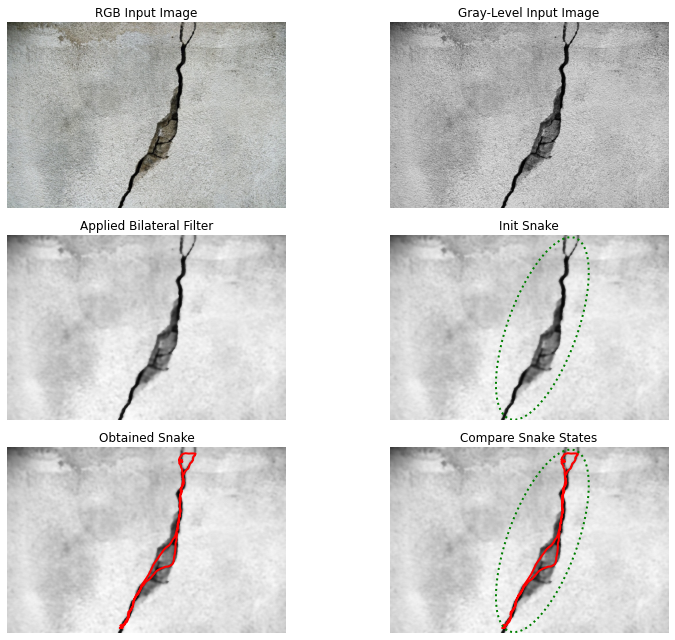

In [4]:
plt.rcParams['figure.figsize'] = (12, 9)
results = []
in_img3 = cv2.imread("./img3.jpg")
I = 1
PR,PC = 3,2
plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3[:,:,::-1])
plt.title("RGB Input Image")
plt.axis("off")


in_img3 = cv2.cvtColor(in_img3,cv2.COLOR_BGR2GRAY)
plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3,cmap="gray")
plt.title("Gray-Level Input Image")
plt.axis("off")


in_img3 = cv2.bilateralFilter(in_img3,13,95,95)
plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3,cmap="gray")
plt.title("Applied Bilateral Filter")
plt.axis("off")



img = in_img3.copy()

s = np.linspace(0, 2*np.pi, 225)
r = 123 + 332*np.sin(s)
c = 605 + 120*np.cos(s)
init = np.array([r, c]).T

theta = np.radians(20)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

init = np.dot(init,R)

snake = active_contour(in_img3, init, alpha=0.01, beta=0.1, gamma=0.01,
                       w_line= -2 , w_edge= 2,
                       max_px_move=3, max_num_iter=5000)


plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3,cmap="gray")
plt.plot(init[:, 1], init[:, 0], ':g', lw=2)
plt.title("Init Snake")
plt.axis("off")

plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3,cmap="gray")
plt.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
plt.title("Obtained Snake")
plt.axis("off")

plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3,cmap="gray")
plt.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
plt.plot(init[:, 1], init[:, 0], ':g', lw=2)
plt.title("Compare Snake States")
plt.axis("off")


plt.tight_layout()
plt.show()


### Img2.jpg

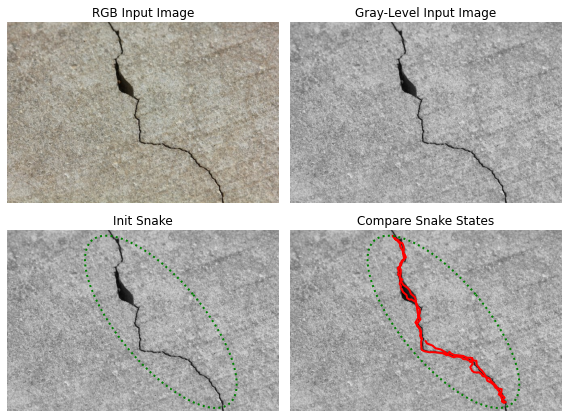

In [11]:
plt.rcParams['figure.figsize'] = (8, 6)
results = []
in_img3 = cv2.imread("./img2.jpg")
I = 1
PR,PC = 2,2
plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3[:,:,::-1])
plt.title("RGB Input Image")
plt.axis("off")


in_img3 = cv2.cvtColor(in_img3,cv2.COLOR_BGR2GRAY)
plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3,cmap="gray")
plt.title("Gray-Level Input Image")
plt.axis("off")



img = in_img3.copy()

s = np.linspace(0, 2*np.pi, 180)
r = 420 + 265*np.sin(s)
c = 145 + 105*np.cos(s)
init = np.array([r, c]).T

theta = np.radians(-40)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
init = np.dot(init,R)



plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3,cmap="gray")
plt.plot(init[:, 1], init[:, 0], ':g', lw=2)
plt.title("Init Snake")
plt.axis("off")


snake = active_contour(in_img3, init, alpha=0.02, beta=0.11, gamma=0.02,
                       w_line= -2 , w_edge= 2,
                       max_px_move=4, max_num_iter=50000,convergence=0.005)



plt.subplot(PR,PC,I)
I+=1
plt.imshow(in_img3,cmap="gray")
plt.plot(snake[:, 1], snake[:, 0], '-r', lw=2)
plt.plot(init[:, 1], init[:, 0], ':g', lw=2)
plt.title("Compare Snake States")
plt.axis("off")


plt.tight_layout()
plt.show()
